In [1]:
import os
from glob import glob
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
TRUE_IMG_PATH='./True/'
FALSE_IMG_PATH='./False/'
pixel_size=64


true_imgs=glob(TRUE_IMG_PATH+'*')
false_imgs=glob(FALSE_IMG_PATH+'*')
all_imgs=true_imgs+false_imgs

print(len(true_imgs))
print (len(false_imgs))

len_imgs=len(true_imgs)+len(false_imgs)

x_input=np.array((len_imgs,pixel_size,pixel_size,1))
x_label=[]

true_label=[]
false_label=[]

def read_img_label(img_list,label):
    label_list=[]
    imgs_array=np.zeros((len(img_list),pixel_size,pixel_size,1))
    for i,img in enumerate(img_list):
        img_array=cv2.resize(cv2.imread(img,0),(pixel_size,pixel_size))
        label_list.append(label)
        imgs_array[i,:,:,0]=img_array
    label_list=np.array(label_list)
    return imgs_array,label_list
        
true_inputs,true_labels = read_img_label(true_imgs,[0,1])
false_inputs,false_labels = read_img_label(false_imgs,[1,0])



        

113
46


(113, 64, 64, 1)


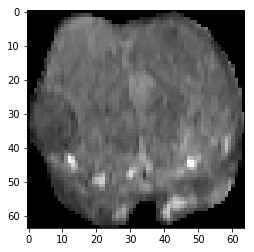

In [3]:
print (true_inputs.shape)

plt.imshow(true_inputs[10,:,:,0],cmap=plt.cm.gray)
plt.show()

def shuffle_data(a,b,r1):
    assert len(a)==len(b)
    r=range(len(a))
    random.shuffle(r,lambda: r1)
    p=np.array(r)
    
    return a[p],b[p]


data=np.vstack((true_inputs,false_inputs))
labels=np.vstack((true_labels,false_labels))


data,labels=shuffle_data(data,labels,0.1)


split_point=int(round(0.8*len(data)))
(x_train,x_val)=(data[:split_point],data[split_point:])
(y_train,y_val)= (labels[:split_point],labels[split_point:])


In [4]:
import numpy as np
import keras

from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping

Using TensorFlow backend.


In [5]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping

import numpy as np
import resnet

os.environ["CUDA_VISIBLE_DEVICES"] = '1'


lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10)
# csv_logger = CSVLogger('resnet18_cifar10.csv')

batch_size = 32
nb_classes = 2
nb_epoch = 200
data_augmentation = False

# input image dimensions
img_rows, img_cols = 64, 64
# The CIFAR10 images are RGB.
img_channels = 1

#
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              nb_epoch=nb_epoch,
              validation_data=(x_val, y_val),
              shuffle=True,
              callbacks=[lr_reducer, early_stopper])
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        validation_data=(x_val, y_val),
                        epochs=nb_epoch, verbose=1, max_q_size=100,
                        callbacks=[lr_reducer, early_stopper, csv_logger])

# model.summary()

Not using data augmentation.


/home/ilab/anaconda2/envs/Dinghow/lib/python2.7/site-packages/ipykernel_launcher.py:39: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 127 samples, validate on 32 samples
Epoch 1/200
127/127 [==============================] - 7s 57ms/step - loss: 1.7099 - acc: 0.6929 - val_loss: 1.6561 - val_acc: 0.7812
Epoch 2/200
127/127 [==============================] - 3s 25ms/step - loss: 1.1274 - acc: 0.9449 - val_loss: 1.5812 - val_acc: 0.8750
Epoch 3/200
127/127 [==============================] - 3s 25ms/step - loss: 1.0604 - acc: 0.9685 - val_loss: 1.5603 - val_acc: 0.8438
Epoch 4/200
127/127 [==============================] - 3s 25ms/step - loss: 1.0355 - acc: 0.9764 - val_loss: 1.7187 - val_acc: 0.8125
Epoch 5/200
127/127 [==============================] - 3s 24ms/step - loss: 1.1142 - acc: 0.9370 - val_loss: 4.7484 - val_acc: 0.2812
Epoch 6/200
127/127 [==============================] - 3s 24ms/step - loss: 0.9874 - acc: 0.9921 - val_loss: 6.2364 - val_acc: 0.1250
Epoch 7/200
127/127 [==============================] - 3s 25ms/step - loss: 0.9508 - acc: 0.9921 - val_loss: 4.2182 - val_acc: 0.2188
Epoch 8/200
127/1

In [6]:
from vis.visualization import visualize_saliency,overlay
from vis.utils import utils
from keras import activations
from vis.visualization import visualize_cam
import matplotlib.cm as cm

i=20
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
# layer_idx = utils.find_layer_idx(model, 0)

# Swap softmax with linear
model.layers[5].activation = activations.linear
model = utils.apply_modifications(model)


In [7]:
index=13

# img=cv2.imread(true_imgs[index],0)
img=cv2.imread('../../CAM-Data/CAM/Result/SegImage.png',0)

# print(true_imgs[index])
# img=cv2.imread('./Predict_Img/3.png',0)

img=cv2.resize(img,(64,64))
print (img.shape)
img=np.reshape(img,(64,64,1))
print (img.shape)

(64, 64)
(64, 64, 1)


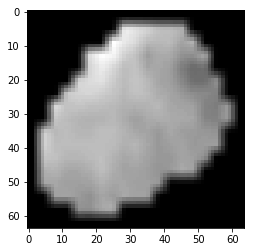

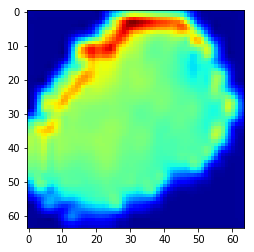

/home/ilab/anaconda2/envs/Dinghow/lib/python2.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [10]:
for t in range(1):
# for t in range(1,30):
#     print (t)
    grads = visualize_cam(model, 5,filter_indices=2, seed_input=img,backprop_modifier='relu')
#     print (grads.shape)
    # Plot with 'jet' colormap to visualize as a heatmap.

#     print (img.shape)

    plt.imshow(img[...,0],cmap=plt.cm.gray)
    plt.show()

    jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
    # plt.imshow(overlay(jet_heatmap, x_val_pic[1]))

    plt.imshow(grads, cmap='jet')

    plt.show()


    from scipy.misc import imsave

    imsave('./Result/G1.jpg',grads)